<a href="https://colab.research.google.com/github/Matrixbrs/-finan-as-python-/blob/main/Benjamim_Op_(MDD)drawdown_at_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
valeu !pip install panda
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install yfinance

  Preparing metadata (setup.py) ... done
  Created wheel for panda: filename=panda-0.3.1-py3-none-any.whl size=7239 sha256=e44b3aab67e1bf7af82224de03ae1c1407acc23b9a6ff1e1c97bd986a3a7f204
  Stored in directory: /root/.cache/pip/wheels/df/5c/39/36f8dae25a1e88d6ec4411dec4a143781e64fdff6897758eec
Successfully built panda


In [ ]:
import pandas as pd                            #rascunho maxdrawd at risco + monte carlos
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.dates as mdates

In [ ]:
carteira = ['XLV', 'XLI', 'EEM', 'MCHI']
peso = [0.20, 0.20, 0.27, 0.33]
dados = yf.download(carteira, start="2022-01-01")['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


In [ ]:
dados_normalizados = dados / dados.iloc[0]
valor_carteira = (dados_normalizados * peso).sum(axis=1)     #normalizando os dados do ponto inicial e calculando a carteira ao longo do tempo


In [ ]:
rolling_max = valor_carteira.cummax()            #calcuando o drawdown e o maximo drawdon
drawdown = valor_carteira / rolling_max - 1
max_drawdown = drawdown.min()
print(f"Máximo Drawdown: {max_drawdown:}")


Máximo Drawdown: -0.22349743688308898


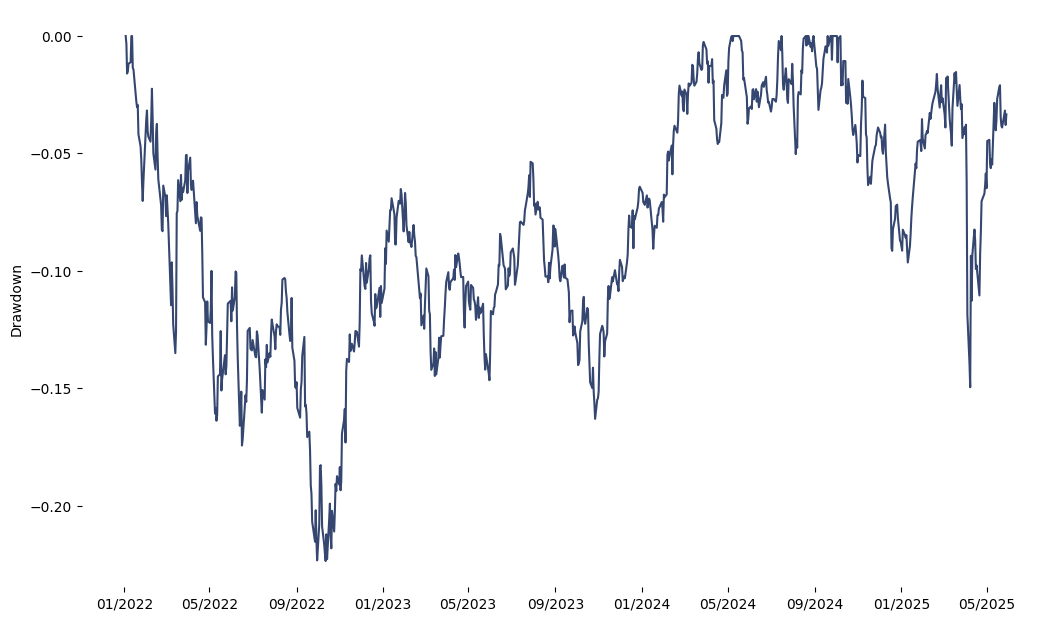

In [ ]:
plt.figure(figsize=(12.5, 7.5))
plt.plot(valor_carteira.index, drawdown, alpha=0.9, color='#1f3360')
ax=plt.gca()
ax.spines['top'].set_visible(False)                                  # o grafico de dispersão drawdown ao longo do periodo
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.ylabel('Drawdown')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.show()

In [ ]:
retornos_diarios = dados.pct_change().dropna()
media_retornos = retornos_diarios.mean()
cov_matrix = retornos_diarios.cov()

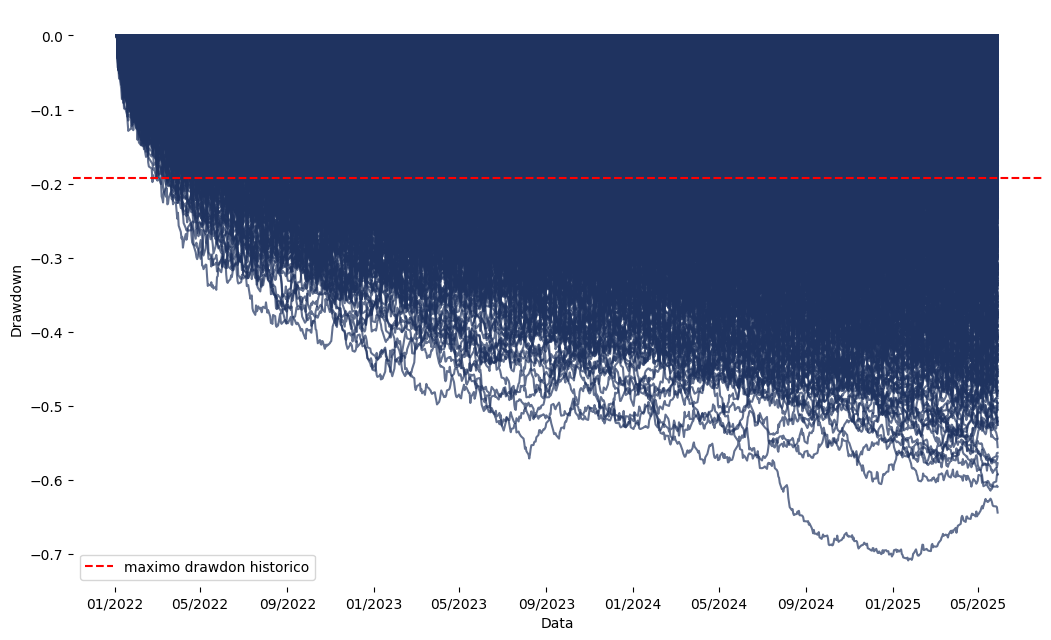

In [ ]:
num_simulacoes = 1000                                #drawdown at risk por simulação monte carlos
dias_simulacao = len(retornos_diarios)

plt.figure(figsize=(12.5, 7.5))
simulated_drawdowns = []

for _ in range(num_simulacoes):
    simulated_returns = np.random.multivariate_normal(media_retornos, cov_matrix, dias_simulacao)
    simulated_returns = pd.DataFrame(simulated_returns, columns=carteira, index=retornos_diarios.index)

    initial_prices = dados.iloc[0]             # caminhos de preço simulados a partir dos retornos
    simulated_prices = initial_prices * (1 + simulated_returns).cumprod()
    simulated_normalized_prices = simulated_prices / simulated_prices.iloc[0]     #valr da carteira
    simulated_portfolio_value = (simulated_normalized_prices * peso).sum(axis=1)

                                 # drawdown simulado
    simulated_rolling_max = simulated_portfolio_value.cummax()
    simulated_drawdown = simulated_portfolio_value / simulated_rolling_max - 1
    max_drawdown=simulated_drawdown.min()
    simulated_drawdowns.append(max_drawdown)

    plt.plot(simulated_portfolio_value.index, simulated_drawdown, alpha=0.7, color='#1f3360')


ax=plt.gca()
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xlabel('Data')
plt.ylabel('Drawdown')
plt.axhline(y=max_drawdown, color='r',linestyle='--',label='maximo drawdon historico')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.legend()
plt.show()

In [ ]:
max_drawdowns_sim=simulated_drawdowns
confidence_level=0.95
mdar_percentile=100*(1-confidence_level)
max_drawdown_at_risk=np.percentile(max_drawdowns_sim,mdar_percentile)
print(f'o maximo drawdon at risk no nivel de confiança de{confidence_level*100},é:{max_drawdown_at_risk:.2%}')

o maximo drawdon at risk no nivel de confiança de95.0,é:-47.69%


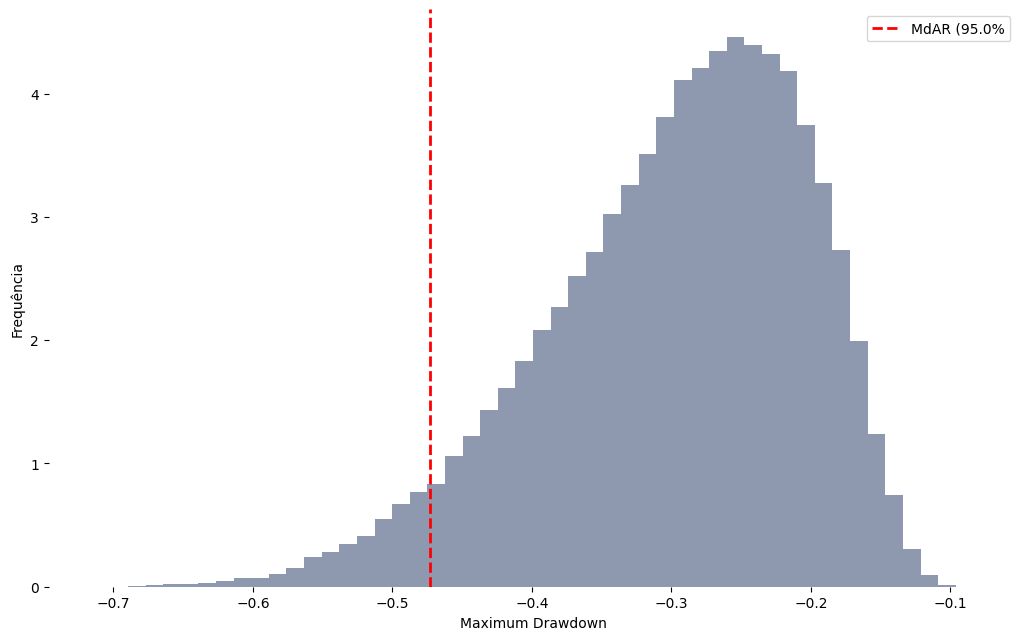

In [ ]:
plt.figure(figsize=(12.5, 7.5))
plt.hist(max_drawdowns_sim, bins=50, density=True, alpha=0.5, color='#1f3360')
plt.axvline(max_drawdown_at_risk, color='red', linestyle='dashed', linewidth=2, label=f'MdAR ({confidence_level*100}%')
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)                           #histograma do drawdown at risk levando em consideração o Var 95% de confiança
ax.spines['bottom'].set_visible(False)
plt.xlabel('Maximum Drawdown')
plt.ylabel('Frequência')
plt.legend()
plt.show()

[*********************100%***********************]  4 of 4 completed
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


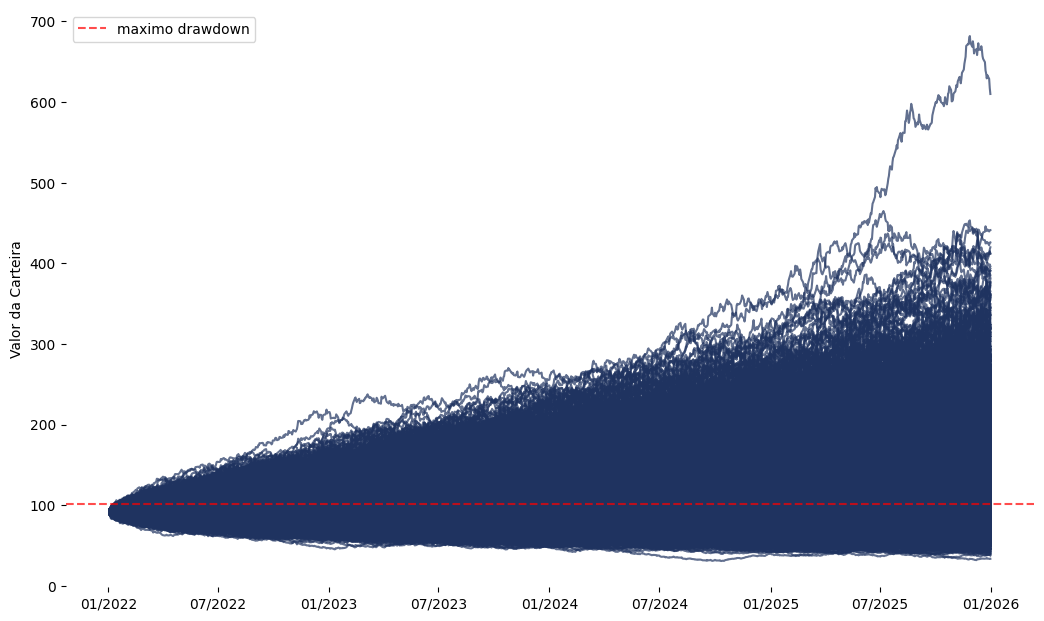

In [ ]:
import yfinance as yf      #  RASCUNDO  MAXIMO DRAW AT RISK COM MODELAGEM MONTE CARLOS               obs rascunho
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
tickers = ['XLV', 'XLI', 'EEM', 'MCHI']
weights = np.array([0.20, 0.20, 0.27, 0.33])
data = yf.download(tickers, start="2010-01-01")['Close']
returns = data.pct_change().dropna()



start_date_sim = "2022-01-01"        # valor da carteira por monte carlos
end_date_sim = "2025-12-31"
num_simulations = 100000
days_in_year = 252

trading_days_sim = len(pd.bdate_range(start=start_date_sim, end=end_date_sim))
initial_price_sim = data.loc[:start_date_sim].iloc[-1] @ weights
mean_returns_daily = returns.mean()
cov_matrix_daily = returns.cov()

simulated_portfolio_values = np.zeros((num_simulations, trading_days_sim))

for i in range(num_simulations):
  simulated_returns_daily=np.random.multivariate_normal(mean_returns_daily, cov_matrix_daily, trading_days_sim)
  simulated_portfolio_returns_daily = simulated_returns_daily @ weights
  simulated_portfolio_values[i, 0] = initial_price_sim * (1 + simulated_portfolio_returns_daily[0])
  for j in range(1, trading_days_sim):
        simulated_portfolio_values[i, j] = simulated_portfolio_values[i, j-1] * (1 + simulated_portfolio_returns_daily[j])

simulated_peak_values = np.maximum.accumulate(simulated_portfolio_values, axis=1)
simulated_drawdowns = (simulated_portfolio_values - simulated_peak_values) / simulated_peak_values



import matplotlib.dates as mdates
plt.figure(figsize=(12.5, 7.5))
for i in range(min(10000, num_simulations)):
      plt.plot(pd.to_datetime(pd.bdate_range(start=start_date_sim, end=end_date_sim)), simulated_portfolio_values[i, :], alpha=0.7, color='#1f3360')

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.ylabel('Valor da Carteira')
plt.axhline(y=102, color='r', linestyle='--', label='maximo drawdown', alpha=0.7)
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.show()

In [ ]:
simulated_drawdowns_array = np.array(simulated_drawdowns)        # maximo drawdown at risk com & de 95% d confiança 45.76%
confidence_level = 0.95
alpha = 1 - confidence_level
max_drawdown_at_risk = np.quantile(simulated_drawdowns_array, alpha)
print(max_drawdown_at_risk)


-0.47660492392725645


In [ ]:
max_drawdowns_sim = simulated_drawdowns_array     # deixando o percentual mais claro dodrawdown at risk com 95% de confiança
confidence_level = 0.95
mdar_percentile = 100 * (1 - confidence_level)
max_drawdown_at_risk = np.percentile(max_drawdowns_sim, mdar_percentile)
print(f"O Maximum Drawdown at Risk (MdAR) no nível de confiança de {confidence_level*100}% é: {max_drawdown_at_risk:.2%}")


O Maximum Drawdown at Risk (MdAR) no nível de confiança de 95.0% é: -47.66%


In [ ]:
print(f'drawdown medio historico:{historical_mean_return}')
print(f'drawdown medio simulado:{max_drawdown}')                   #drawd medio dos etfs

drawdown medio historico:Ticker
EEM     0.000088
MCHI    0.000151
XLI     0.000503
XLV     0.000058
dtype: float64
drawdown medio simulado:-0.22349742269631678


In [ ]:
print(max_drawdown)                          # testando o historico max drawdown com preiodo

-0.22349742269631678


In [ ]:
print(np.percentile(historical_drawdown, 5))


-0.15835435727221173


In [ ]:
print(np.percentile(historical_drawdown, 10))


-0.13698283865862856


In [ ]:
print(np.percentile(historical_drawdown, 25))


-0.10885657623592172


<ipython-input-28-ab1490b272bc>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


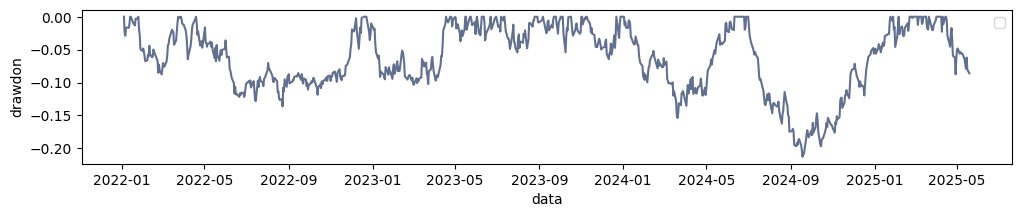

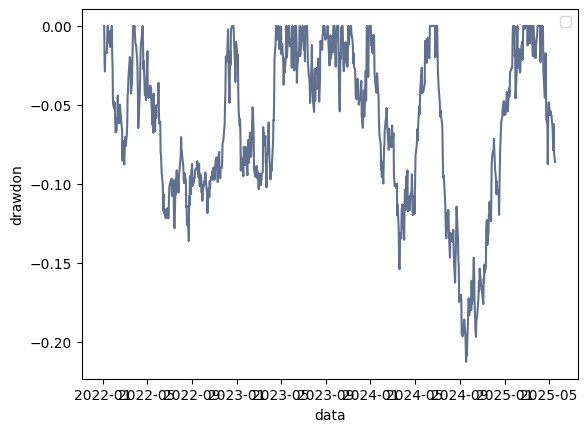

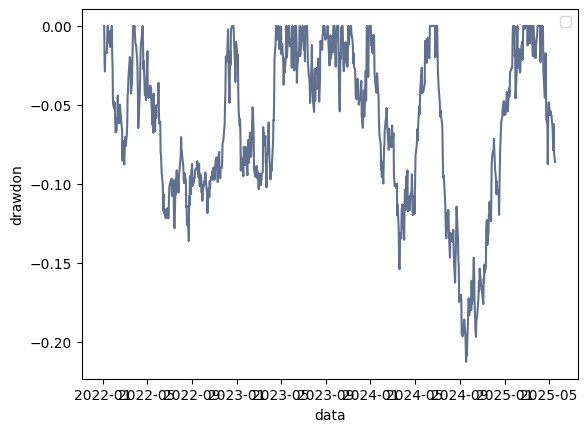

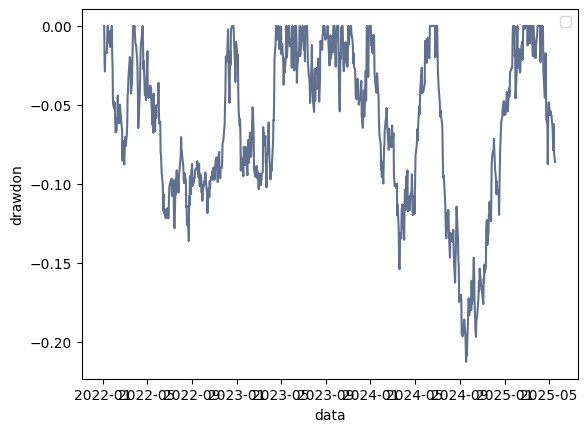

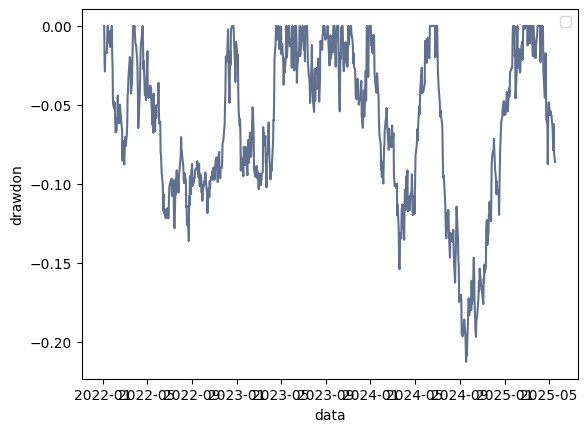

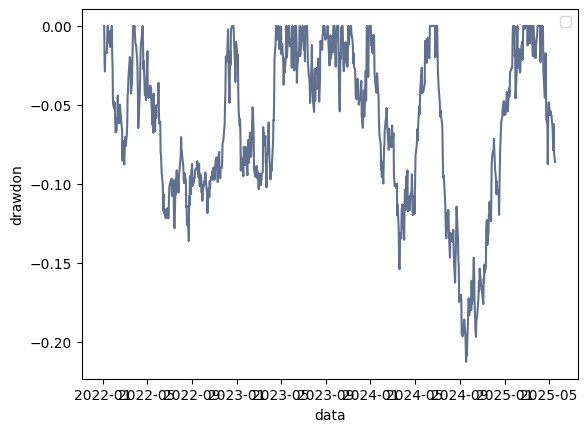

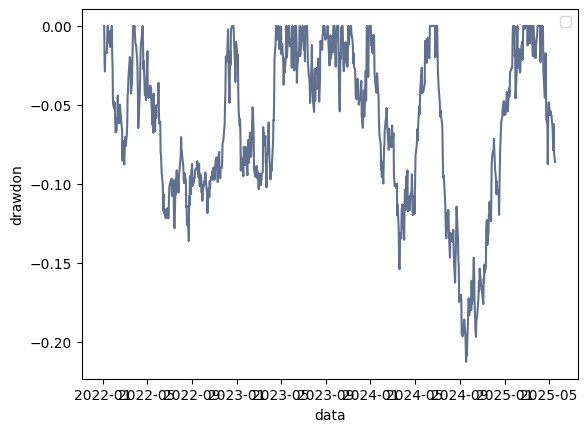

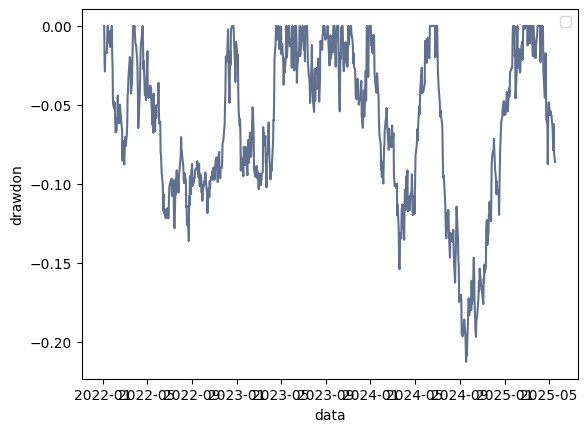

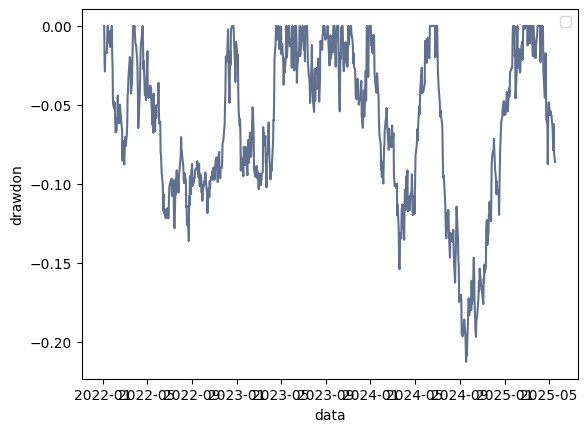

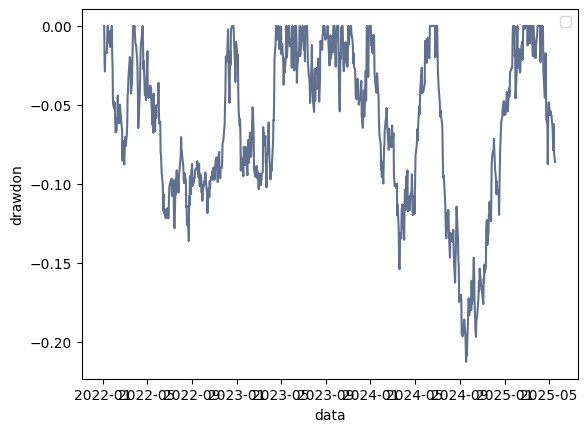

In [ ]:
import matplotlib.dates as mdates           #funç multipl carteir                               rascunho
plt.figure(figsize=(12,2))
for i in range(min(10, num_simulacoes)):
  plt.plot(simulated_portfolio_value.index, simulated_drawdown, alpha=0.7, color='#1f3360')
  plt.xlabel('data')
  plt.ylabel('drawdon')
  plt.legend()
  plt.show()
